In [1]:
import numpy
from matplotlib import pyplot
%matplotlib inline

In [2]:
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

In [3]:
def rho_shock_tube(x, rhoL, rhoR):
    rho = numpy.ones_like(x)
    mask1 = numpy.where(x < 0.0)
    mask2 = numpy.where(0.0 <= x)
    rho[mask1] = rhoL
    rho[mask2] = rhoR
    return rho

In [4]:
def u_shock_tube(x, uL, uR):
    u = numpy.ones_like(x)
    mask1 = numpy.where(x < 0.0)
    mask2 = numpy.where(0.0 <= x)
    u[mask1] = uL
    u[mask2] = uR
    return u

In [5]:
def P_shock_tube(x, PL, PR):
    P = numpy.ones_like(x)
    mask1 = numpy.where(x < 0.0)
    mask2 = numpy.where(0.0 <= x)
    P[mask1] = PL
    P[mask2] = PR
    return P

In [6]:
nx = 81
L = 10.0
dx = 0.25
dt = 0.0002
gamma = 1.4
rhoL = 1.0
rhoR = 0.125
uL = 0.0
uR = 0.0
PL = 100000.0
PR = 10000.0
nt = 50

x = numpy.linspace(-L, L, num=nx)

rho0 = rho_shock_tube(x, rhoL, rhoR)
u0 = u_shock_tube(x, uL, uR)
P0 = P_shock_tube(x, PL, PR)

In [7]:
def e_def(P, rho, gamma):
    e = P / ((gamma - 1) * rho)
    return e

In [8]:
e0 = e_def(P0, rho0, gamma)

In [9]:
def U_function(rho, e, u):
    U = numpy.empty([3, 81])
    U[0, :] = rho
    U[1, :] = u * rho
    U[2, :] = rho * (e + u**2 / 2)
    return U

In [10]:
U0 = U_function(rho0, e0, u0)

In [11]:
def flux(U, gamma):
    F = numpy.empty([3, 81])
    F[0] = U[1]
    F[1] = U[1]**2 / U[0] + (gamma - 1) * (U[2] - 0.5 * U[1]**2 / U[0])
    F[2] = (U[2] + (gamma - 1) * (U[2] - 0.5 * U[1]**2 / U[0])) * (U[1] / U[0])
    return F

In [12]:
def rich(U0, nt, gamma, dt, dx, bc_values):
    U = U0.copy()
    U_half = U.copy()
    for n in range(nt):
        F = flux(U, gamma)
        U_half[:,1:-1] = 0.5 * (U[:,2:] + U[:,1:-1]) - (dt / (2*dx)) * (F[:,2:] - F[:,1:-1])
        F = flux(U_half, gamma)
        U[:,1:-1] = U[:,1:-1] - dt / dx * (F[:,1:-1] - F[:,:-2])
        U[:,0] = bc_values[0]
        U[:,-1] = bc_values[1]
    return U

In [13]:
U = rich(U0, nt, gamma, dt, dx, (U0[:, 0], U0[:, -1]))
Q = U[1] / U[0]
W = (gamma - 1) * (U[2] - 0.5 * U[1]**2 / U[0])
E = U[0]

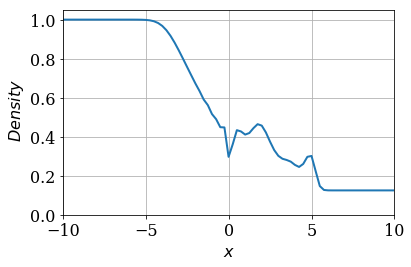

In [14]:
pyplot.xlabel(r'$x$')
pyplot.ylabel(r'$\ Density$')
pyplot.grid()
line = pyplot.plot(x, E,
                   color='C0', linestyle='-', linewidth=2)[0]
pyplot.xlim(-L, L)
pyplot.ylim(0.0, 1.05)
pyplot.tight_layout()

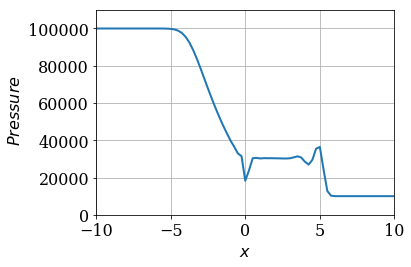

In [15]:
pyplot.xlabel(r'$x$')
pyplot.ylabel(r'$\ Pressure$')
pyplot.grid()
line = pyplot.plot(x, W,
                   color='C0', linestyle='-', linewidth=2)[0]
pyplot.xlim(-L, L)
pyplot.ylim(0.0, 110000)
pyplot.tight_layout()

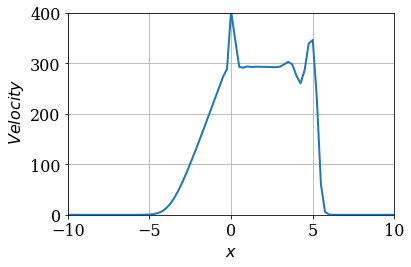

In [16]:
pyplot.xlabel(r'$x$')
pyplot.ylabel(r'$\ Velocity$')
pyplot.grid()
line = pyplot.plot(x, Q,
                   color='C0', linestyle='-', linewidth=2)[0]
pyplot.xlim(-L, L)
pyplot.ylim(0.0, 400)
pyplot.tight_layout()

In [17]:
print(Q[50],
      W[50],
      E[50])

292.6114715268265 30250.89016757203 0.3746914026476012
